In [1]:
import os
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import BertTokenizerFast
import shap
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)

In [2]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig,
                                  BertForSequenceClassification)

from pytorch_transformers import AdamW, WarmupLinearSchedule                                

In [3]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizerFast)
}
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']

In [4]:
def get_labels_from_label_dict(lbl_dict_path):
        line_id = 0
        labels = []
        for line in open(lbl_dict_path, encoding='utf8'):
            fds = line.strip().split(' ')
            assert len(fds) == 2, 'incorrect format {}'.format(line)
            lbl = fds[0]
            fid = int(fds[1])
            assert fid == line_id, 'id not correct {} -- {}'.format(fid, line_id)
            labels.append(lbl)
            line_id += 1
        return labels

In [5]:
def read_fasttext(infile):
        data = []
        # HACK for windows the first line causes utf problem...
        fFirstline = True
        for line in open(infile, 'r', encoding='utf-8-sig'):
            # __label__Step in st george wharf tower ) have modern and luxurious installations .
            fields = line.strip().split()
            words, label = [], ''
            for fd in fields:
                if fd.startswith('__label__'):
                    label = fd
                else:
                    words.append(fd)
            if label != '' and len(words) > 0:
                data.append((label, ' '.join(words)))

        return data

In [6]:
args = {
'data_dir':'C:\\Users\\ryserrao\\Microsoft_work\\AIPLATFORM_SHAP\\PPT_Text_to_Icon_Data\\Turing_Text2Icon_Code_and_Model\\outputs',
'model_name_or_path':'ft_set12_256x2_pcln2sc_nowiki.py_e10_wu02_bs8_ts08_sc12_lr7e-5',
'data_path':'test_mturk.txt',
'task_name':'text2content',
'do_lower_case':True,
'lbl_dict_path' : 'train.txt.lbl.dict.txt',
'max_seq_len':32
}
labels = get_labels_from_label_dict(os.path.join(args['data_dir'], args['lbl_dict_path']))
num_labels = len(labels)

In [7]:
labels_to_idx = {}
for i,label in enumerate(labels):
    labels_to_idx[label]=i

In [46]:
data = pd.DataFrame(read_fasttext(os.path.join(args['data_dir'], args['data_path'])), columns=['Label','Sentence'])

In [42]:
data.head()

,Label,Sentence
0,__label__Acorn,The US Open tennis final was very exciting
1,__label__Add,there is alway an addition to the party PUNC
2,__label__Advertising,we specialize in outdoor billboard advertising PUNC
3,__label__Africa,the continent of africa PUNC
4,__label__Airplane,PUNC it PUNC s a symbol of airplane mode icon PUNC while travelling on a plane PUNC you have to put your mobile on this mode PUNC so PUNC that you wo n't get your network in the plane PUNC PUNC


In [10]:
config = config_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), num_labels=num_labels, finetuning_task=args['task_name'])




In [11]:
tokenizer = tokenizer_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']), do_lower_case=args['do_lower_case'])

In [13]:

model = model_class.from_pretrained(os.path.join(args['data_dir'],args['model_name_or_path']),config=config).cuda()

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "text2content",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "num_labels": 865,
  "output_attentions": false,
  "output_hidden_states": false,
  "pooler": "cls",
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [14]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=args['max_seq_len'],truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

In [43]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

In [44]:
shap_values_multiclass = explainer(data['Sentence'][:1000])

Partition explainer: 695it [00:27, 25.48it/s]


In [28]:
def bar_plot(class_index):
    compute_shap=copy.copy(shap_values_multiclass.mean(0))
    mask=compute_shap.values[:,class_index]>=0
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    compute_shap.base_values=compute_shap.base_values[class_index]
    compute_shap.data=None
    shap.plots.bar(compute_shap)

In [29]:
def text_plot(class_index,start_idx,end_idx):
    shap_values = copy.copy(shap_values_multiclass[:])
    if len(shap_values.base_values.shape) == 1:
        shap_values.values = shap_values.values[:,class_index]
        shap_values.hierarchical_values = shap_values.hierarchical_values[:,class_index]
        shap_values.base_values = shap_values.base_values[class_index]
    else:
        for i in range(start_idx,end_idx):
            shap_values.values[i] = shap_values.values[i][:,class_index]
            shap_values.hierarchical_values[i] = shap_values.hierarchical_values[i][:,class_index]
        shap_values.base_values = shap_values.base_values[:,class_index]
    shap.plots.text(shap_values[start_idx:end_idx])

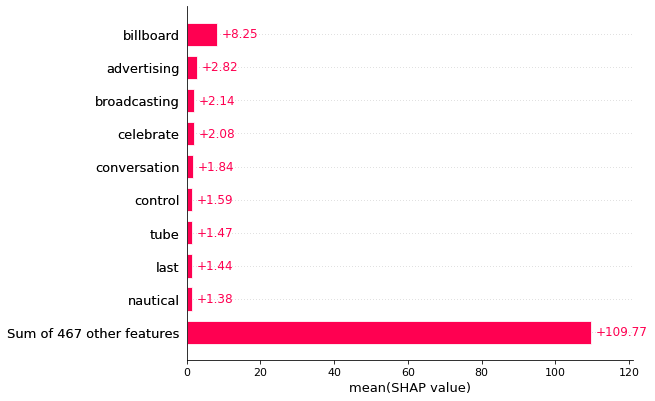

In [30]:
label='__label__Advertising'
bar_plot(labels_to_idx[label])

In [48]:
label='__label__Fire'
text_plot(labels_to_idx[label],231,232)

In [32]:
data

,Label,Sentence
0,__label__Acorn,an acorn PUNC
1,__label__Add,there is alway an addition to the party PUNC
2,__label__Advertising,we specialize in outdoor billboard advertising PUNC
3,__label__Africa,the continent of africa PUNC
4,__label__Airplane,PUNC it PUNC s a symbol of airplane mode icon PUNC while travelling on a plane PUNC you have to put your mobile on this mode PUNC so PUNC that you wo n't get your network in the plane PUNC PUNC
5,__label__AlarmClock,do n't forget to set your alarm clock PUNC
6,__label__Ambulance,in case of an emergency
7,__label__Anchor,the outline of an anchor PUNC
8,__label__AngelFaceOutline,good behavior makes us more angelic PUNC
9,__label__Antarctica,click to see flight dates to antarctica PUNC
